# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели, введение в конкурсную задачу


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 апреля 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 апреля, -4 балла после 06:00 24 апреля, -6 баллов после 06:00 1 мая

Имеется ввиду именно сдача данного ДЗ, а не конечного результата по конкурсу (см ниже).<br\>
Жесткий дедлайн по конкурсной задаче - 14 мая 23:59 GMT.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle

import seaborn as sns

from tqdm import tnrange, tqdm_notebook

%matplotlib inline

plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [6]:
USER_NAME = "Лобанов".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print("Имплементируйте обучение логистической регрессии с {} регуляризацией с "
      "помощью метода {} Stochastic Gradient Descent (SGD)".format(
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
))

Имплементируйте обучение логистической регрессии с L1 регуляризацией с помощью метода  Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Считать градиент по мини батчам
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

## Имплементация (6 баллов)

In [128]:
from sklearn.base import BaseEstimator, ClassifierMixin

def addShift(x):
    return np.hstack((np.ones((x.shape[0],1)), x))

def h(theta, x):
    return (1 / ( 1+ np.exp(-x.dot(theta)))).reshape((x.shape[0],1))

def mySign(X):
    res = []
    for val in X:
        if val > 1e-5:
            res.append(1)
        elif val < -1e-5:
            res.append(-1)
        else:
            res.append(0)
    return np.asarray(res).reshape(X.shape)
            

def getGrad(theta, X, Y, alpha):
    res = (h(theta, X) - Y).T.dot(X)/X.shape[0]
    #return res.flatten()
    regs = alpha* mySign(theta) / X.shape[0]
    regs[0] = 0
    return (res + regs).flatten()
    
def getJ(theta, X, Y, alpha):
    return (((h(theta, X) - Y)**2).sum() + alpha* np.sum(np.abs(theta))) / X.shape[0]

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=20, shifted=True ):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.shifted = shifted
        
    def fit(self, X, Y=None):
        if self.shifted:
            new_X = addShift(X)
        else:
            new_X = X
        mat_Y = Y.reshape((Y.shape[0],1))
        self.J_list = []
        cur_theta = np.random.randn(new_X.shape[1])
        for iter_num in range(1,self.max_epoch+1):
            inds = shuffle(list(range(X.shape[0])))
            for val in X[inds]:
                cur_theta -= self.alpha/iter_num * getGrad(cur_theta, new_X, mat_Y, self.alpha)
            self.J_list.append(getJ(cur_theta, new_X, mat_Y, self.alpha))
        self.coef_ = cur_theta
        return self
    
    def partial_fit(self, X, Y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        return np.rint(self.predict_proba(X))
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        if self.shifted:
            return h(self.coef_, addShift(X))
        else:
            return h(self.coef_, X)
    
print(h(np.asarray([1,2,3]),np.asarray([[2,-1,-2.2],[2,-1,-2.2],[2,-1,-2.2]])))
print(getGrad(
    np.asarray([1.,2.]),
    np.asarray([[2,-1],[2.9,-2.2],[2,-2.2]]),
    np.asarray([[1],[0],[1]]),
    2
))

[[ 0.00135852]
 [ 0.00135852]
 [ 0.00135852]]
[-0.76820686  1.37189464]


## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

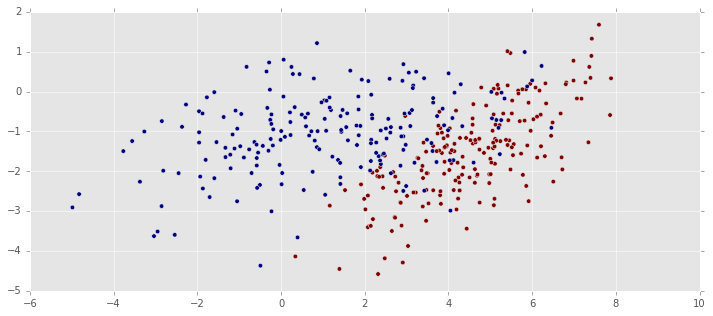

(400, 2)


In [107]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)
plt.show()
print(X.shape)

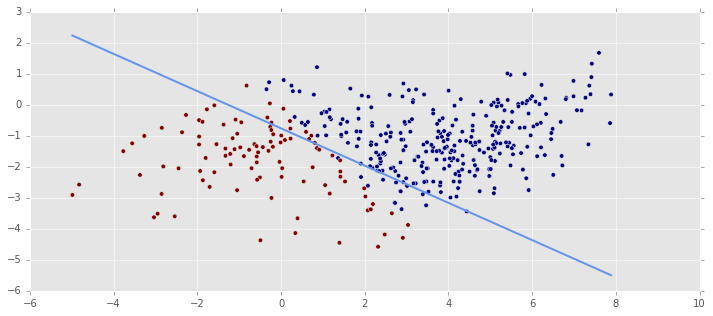

Коэффициенты:  [-0.76023653 -0.60071235]


In [121]:
model = MySGDClassifier(C=2,shifted=False)
model.fit(X, y)
plt.scatter(X[:,0], X[:,1], c=model.predict(X))

line_x = np.linspace(X.min(axis=0)[0], X.max(axis=0)[0])
line_y = model.coef_[1]*line_x + model.coef_[0]
lw = 2
plt.plot(line_x, line_y, color='cornflowerblue', linestyle='-',linewidth=lw)
plt.show()
print("Коэффициенты: ", model.coef_)

## Анализ сходимости (2 балл)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

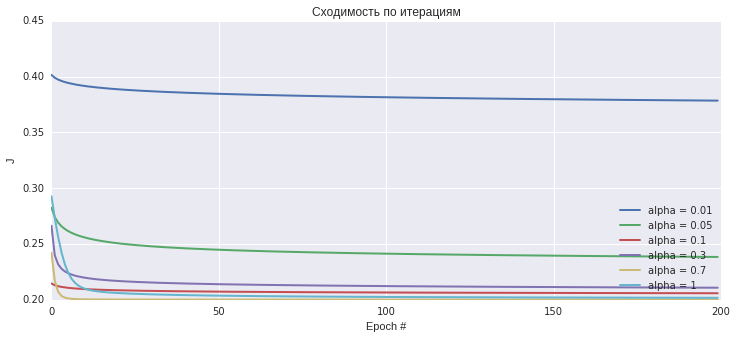

In [147]:
alphas = [0.01,0.05,0.1,0.3,0.7,1]
cols = sns.color_palette(None, n_colors=len(alphas))

J_s = [MySGDClassifier(alpha=alpha,max_epoch=200,C=0.5,shifted=False).fit(X, y).J_list for alpha in alphas]
for ind, J_list in enumerate(J_s):
    plt.plot(J_list, color=cols[ind], linestyle='-',linewidth=2, label="alpha = {}".format(alphas[ind]))
plt.ylabel("J")
plt.xlabel("Epoch #")
plt.legend(loc='lower right')
plt.title("Сходимость по итерациям")
plt.show()

# Введение в конкурсную задачу

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

### Правила
* Объединяться в команды по правилам конкурса можно, но по правилам нашего курса - нельзя)
* Вы можете использовать любой алгоритм, даже неизученный в нашем курсе (если на защите сможете объяснить как он работает)
* Имейте ввиду, что вы должны отправить результаты строго до 14 мая 23:59 GMT на сайт соревнования (раздел submission). Без результата в leaderboard оценка выставлена не будет.

## Данные

Для того, чтобы получить данные необходимо зарегистрироваться на сайте соревнования. 

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


Данные поставляются в двух форматах:
* В формате json содержится полная информация по текущему состоянию раунда
* В табличном формате упрощенная аггрерированная информация по текущему состоянию раунда

В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если данные не будут помещаться вам с оперативную память, рекомендуется совершить предобработку в python, а  моделирование выполнять с помощью [vowpal wabbit](https://github.com/JohnLangford/vowpal_wabbit).

In [172]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))

# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [173]:
df_data.shape

(500000, 45)

In [174]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
#df_data = df_data.set_index('gamestate_id')

In [175]:
df_data.head().T

,0,1,2,3,4
gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10


In [177]:
# Распределение классов
df_data.decision.mean()
# Примерно поровну

0.50470199999999998

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощьб one-hot кодирования, добавьте к датасету и удалите прежние столбцы

In [ ]:
## Youd Code Here

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Обучите модуль из первой части этого ДЗ на данных

In [184]:
from sklearn.linear_model import LogisticRegression
tmp_data = df_data.copy()
del tmp_data["decision"]
del tmp_data["player_hero_card_id"]
del tmp_data["opponent_hero_card_id"]
del tmp_data["gamestate_id"]

X = tmp_data.as_matrix()
del tmp_data
Y = df_data.decision
X.shape
clf = LogisticRegression().fit(X,Y)# MySGDClassifier(alpha=1,max_epoch=10,C=0.5,shifted=True).fit(X, Y)

## Применение модели (3 балла)
#### Задание
* Загрузите тестовые данные
* Выполните те же операции с датасетом, что и с обучающей выборкой
* Примените модель и загрузите решение на страницу конкурса
* Напечатайте ваш ник и оценку качества, полученную после загрузки

Судя по описанию, submission file должен состоять из одного столбца с числами, соответствующим вероятностям победы игрока.

In [185]:
df_test = pd.read_csv("testData_tabular.csv", sep=',')
df_test.columns = df_test.columns.str.replace('.', '_')

del df_test["decision"]
del df_test["player_hero_card_id"]
del df_test["opponent_hero_card_id"]
del df_test["gamestate_id"]

X_test = df_test.as_matrix()
l = clf.predict_proba(X_test).flatten().tolist()
with open("out.txt","w") as f:
    for cur in l:
        f.write("{}\n".format(cur))

hippo23 `0.7202`